# Bag-of-Words Classification
---

In [1]:
import os, sys
import tarfile
import time
import random
import pickle
from glob import glob

import gdown

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
caltech_url = 'https://drive.google.com/uc?id=1enYdrGFhROlTQkvtUooRl4H8oAbGmyXl'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = 'vocab.pkl'

# Dataset

## 1. Download Caltech-101 dataset

In [3]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Downloading Caltech-101')
    if not os.path.exists(caltech_filename) or os.path.getsize(caltech_filename) != 131740031:
        gdown.download(caltech_url, caltech_filename, quiet=False)
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Caltech-101 dataset checked


## 2. Setup Data

# Dense SIFT(PHOW) and Visual Words

Select 15 train/test images for each class
done


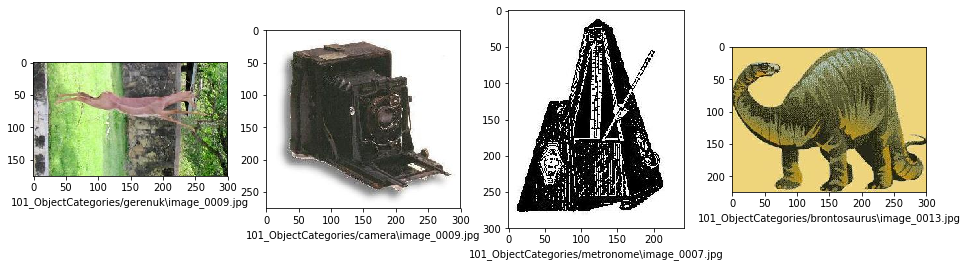

In [4]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

## 1. SIFT helper functions

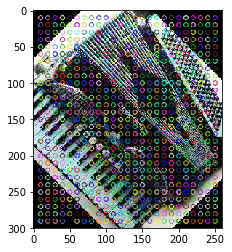

In [5]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
kp, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp, None)
plt.imshow(cv2.cvtColor(im_sift, cv2.COLOR_BGR2RGB))

## 2. Visual Words(Train Vocabulary)

In [6]:
# Train vocabulary
if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    # Total number of PHOW may be different.
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in sublist]
    temp = random.sample(temp, 30)
    for fpath in temp:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))
    
    print('Saving...') 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)

print('Done!')

Load the trained visual words...
Done!


In [7]:
# Works only when vocab.pkl is first created
try:
    import collections
    myCounter = collections.Counter(bestLabels.flatten())
    plt.plot(sorted(myCounter.values()))    
except NameError:
    pass

# Classification - SVM

## Spatial Histogram

In [8]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=10, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning - 2x2
    binX = 2; binY = 2;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    
    # Spatial Binning - 4x4
    ###########################
    ###  START CODE HERE_1  ###
    
    # Complete temp
    binX = 4; binY = 4;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()    
    
    #####  END CODE HERE   ####
    ###########################

    hist = np.concatenate((hist, temp), axis=0)
    hist /= np.sum(hist)
    return hist    

## 1. Genarate spatial histogram for Training Images

In [9]:
# Extract spatial histogram for all training images
print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c, end=' '), 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
accordion airplanes anchor ant BACKGROUND_Google barrel bass beaver binocular bonsai brain brontosaurus buddha butterfly camera cannon car_side ceiling_fan cellphone chair chandelier cougar_body cougar_face crab crayfish crocodile crocodile_head cup dalmatian dollar_bill dolphin dragonfly electric_guitar elephant emu euphonium ewer Faces Faces_easy ferry flamingo flamingo_head garfield gerenuk gramophone grand_piano hawksbill headphone hedgehog helicopter ibis inline_skate joshua_tree kangaroo ketch lamp laptop Leopards llama lobster lotus mandolin mayfly menorah metronome minaret Motorbikes nautilus octopus okapi pagoda panda pigeon pizza platypus pyramid revolver rhino rooster saxophone schooner scissors scorpion sea_horse snoopy soccer_ball stapler starfish stegosaurus stop_sign strawberry sunflower tick trilobite umbrella watch water_lilly wheelchair wild_cat windsor_chair wrench yin_yang 
done!


## 2. Train SVM

In [10]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0).astype(np.float32)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)

print("train_bow: ", str(train_bow.shape))
print("train_labels: ", str(train_labels.shape))

Setting training data(BoW, label) for SVM
train_bow:  (1530, 12000)
train_labels:  (1530, 1)


In [11]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

print('Done!')

Training SVM...
Elapsed time: 29.86991810798645s
Done!


In [12]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.992810


## 3. Test trained SVM

In [13]:
# Extract spartial histogram for all test images

print('Extract spartial histogram for all test images\n')
BoW_test_ll = []

###########################
###  START CODE HERE_2  ###

# Get Bow_test_ll
for c, image_list in zip(classes, test_image_ll):
    print(c, end=' ')
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_test_ll.append(temp)
        
#####  END CODE HERE   ####
###########################
   
print('\ndone!')

Extract spartial histogram for all test images

accordion airplanes anchor ant BACKGROUND_Google barrel bass beaver binocular bonsai brain brontosaurus buddha butterfly camera cannon car_side ceiling_fan cellphone chair chandelier cougar_body cougar_face crab crayfish crocodile crocodile_head cup dalmatian dollar_bill dolphin dragonfly electric_guitar elephant emu euphonium ewer Faces Faces_easy ferry flamingo flamingo_head garfield gerenuk gramophone grand_piano hawksbill headphone hedgehog helicopter ibis inline_skate joshua_tree kangaroo ketch lamp laptop Leopards llama lobster lotus mandolin mayfly menorah metronome minaret Motorbikes nautilus octopus okapi pagoda panda pigeon pizza platypus pyramid revolver rhino rooster saxophone schooner scissors scorpion sea_horse snoopy soccer_ball stapler starfish stegosaurus stop_sign strawberry sunflower tick trilobite umbrella watch water_lilly wheelchair wild_cat windsor_chair wrench yin_yang 
done!


In [14]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])


###########################
###  START CODE HERE_3  ###

# Get test_bow, text_label.
for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])
    test_labels.extend([i] * len(BoW_list))

test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTrain*numClasses,1))

#####  END CODE HERE   ####
###########################


print(test_bow.shape)
print(test_labels.shape)
# => test_bow: (1530, 200), test_labels: (1530,1)

Setting test data(BoW, label) for SVM
(1530, 12000)
(1530, 1)


In [15]:
# Test Accuracy may be different.
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: {:6}'.format(np.average(test_preds == test_labels)))

Test Accuracy: 0.41045751633986927


## 4. Sample Results

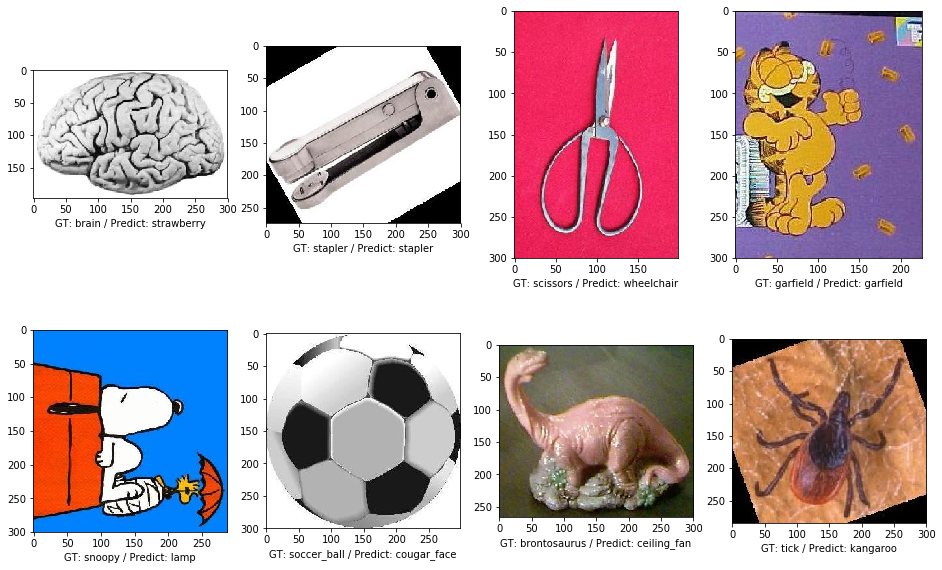

In [16]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, r_c in enumerate(random.sample(range(len(classes)), 8)):
    # Random sample image from given class
    r_i = random.sample(range(numTest), 1)
    fpath = train_image_ll[r_c][r_i[0]]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    
    # Get predicted label
    test_res = int(test_preds[r_c * numTest + r_i[0]][0])
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: {} / Predict: {}".format(classes[r_c], classes[test_res]))

# Classify sample image

- Extract Dense SIFT BoW with `getImageDescriptor()`
- Normalize the bow with Hellinger's kernel
- Predict using the SVM classifier we have trained so far(`svm` instance)

Text(0.5, 0, 'Prediction: yin_yang')

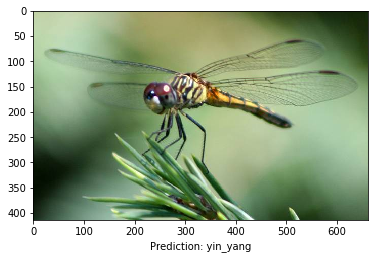

In [25]:
img_fpath = './dragonfly.jpg'
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)

###########################
###  START CODE HERE_4  ###
# Extract Image Descriptor
temp = getImageDescriptor(img)    

# Hellinger's kernel
temp = np.sqrt(bow)
temp -= np.average(temp)
if np.std(temp) != 0:
    temp /= np.std(temp)
temp = temp.reshape(1, -1)

# Prediction
prediction = int(svm.predict(temp)[1])
#####  END CODE HERE   ####
###########################

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))

In [18]:
# Desired output (ceiling fan, rhino, and so on.)